In [99]:
import gzip
import random
import matplotlib.pyplot as plt
from collections import defaultdict

### Question 1

In [81]:
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

In [82]:
train = []
for l in readGz("train.json.gz"):
    train.append(l)

In [83]:
notPurchased = []
for i in range(0, 100000):
    user = random.randint(0, 99999)
    product = random.randint(0, 99999)
    v = {'reviewerID' : 0,
        'itemID' : 0}
    v['reviewerID'] = train[user]['reviewerID']
    v['itemID'] = train[user]['itemID']
    notPurchased.append(v)

In [84]:
validation = train[100000:]
train = train[:100000]

In [85]:
validation = validation + notPurchased

In [86]:
### Would-purchase baseline: just rank which businesses are popular and which are not, and return '1' if a business is among the top-ranked

businessCount = defaultdict(int)
totalPurchases = 0

for l in train:
  user,business = l['reviewerID'],l['itemID']
  businessCount[business] += 1
  totalPurchases += 1

In [87]:
mostPopular = [(businessCount[x], x) for x in businessCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
  count += ic
  return1.add(i)
  if count > totalPurchases/2: break

In [88]:
validationResult = []
expectedResult = []
i = 0
for v in validation:
    if v['itemID'] in return1:
        validationResult.append(1)
    else:
        validationResult.append(0)
    if i < 100000:
        expectedResult.append(1)
    else:
        expectedResult.append(0)
    i = i+1

In [89]:
comparison = list(zip(validationResult, expectedResult))
accuracyV = [v[0] == v[1] for v in comparison]
accuracy = sum(accuracyV)/len(accuracyV)

In [90]:
accuracy

0.471645

### Question 2

In [96]:
### Would-purchase baseline: just rank which businesses are popular and which are not, and return '1' if a business is among the top-ranked

def predict(X, percentile):
    return1 = set()
    count = 0
    for ic, i in mostPopular:
      count += ic
      return1.add(i)
      if count > totalPurchases*percentile: break

    validationResult = []
    for v in X:
        if v['itemID'] in return1:
            validationResult.append(1)
        else:
            validationResult.append(0)
            
    return validationResult

def modelAccuracy(y, real_y):
    comparison = list(zip(y, real_y))
    accuracyV = [v[0] == v[1] for v in comparison]
    return sum(accuracyV)/len(accuracyV)

In [101]:
percent = []
res = []
for i in range(1, 100):
    percentile = i/100
    percent.append(percentile)
    result = predict(validation, percentile)
    acc = modelAccuracy(result, expectedResult)
    res.append(acc)

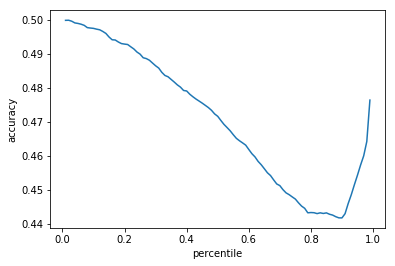

In [102]:
plt.plot(percent, res)
plt.xlabel('percentile')
plt.ylabel('accuracy')
plt.show()

The best performance is achieved when the model predicts all pair with either True of False. In both cases the accuracy is 50%

### Question 3

In [150]:
allUsers = list(set([v['reviewerID'] for v in train]))
users = defaultdict(list)

for user in allUsers:
    categories = [v['categories'] for v in train if v['reviewerID'] == user]
    catList = []
    for cat in categories:
        for c in cat:
            for x in c:
                catList.append(x)
    users[user] = list(set(catList))

In [160]:
vb = [v['categories'] for v in train if v['itemID'] == 'I402344648'][0]
for c in vb:
    print(c)

['Clothing, Shoes & Jewelry', 'Women']
['Clothing, Shoes & Jewelry', 'Novelty, Costumes & More', 'Novelty', 'Clothing', 'Women', 'Leggings']


In [ ]:
predictions = open("predictions_Purchase.txt", 'w')
for l in open("pairs_Purchase.txt"):
    if l.startswith("reviewerID"):
        #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')

    if u in users:
        itemCats = [v['categories'] for v in train if v['itemID'] == i]
        realCats = []
        for cat in itemCats:
            for c in cat:
                for x in c:
                    realCats.append(x)
        realCats = list(set(realCats))
        
        if any(x in users[u] for x in realCats):
            predictions.write(u + '-' + i + ",1\n")
        else:
            predictions.write(u + '-' + i + ",0\n")
    else:
        predictions.write(u + '-' + i + ",0\n")

predictions.close()

In [41]:
### Rating baseline: compute averages for each user, or return the global average if we've never seen the user before

allRatings = []
userRatings = defaultdict(list)
for l in train:
  user,business = l['reviewerID'],l['itemID']
  allRatings.append(l['rating'])
  userRatings[user].append(l['rating'])

In [42]:
globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
for u in userRatings:
  userAverage[u] = sum(userRatings[u]) / len(userRatings[u])

In [43]:
predictions = open("predictions_Rating.txt", 'w')
for l in open("pairs_Rating.txt"):
  if l.startswith("reviewerID"):
    #header
    predictions.write(l)
    continue
  u,i = l.strip().split('-')
  if u in userAverage:
    predictions.write(u + '-' + i + ',' + str(userAverage[u]) + '\n')
  else:
    predictions.write(u + '-' + i + ',' + str(globalAverage) + '\n')

predictions.close()

In [ ]:
### Category prediction baseline: Just consider some of the most common words from each category

catDict = {
  "Women": 0,
  "Men": 1,
  "Girls": 2,
  "Boys": 3,
  "Baby": 4
}

predictions = open("predictions_Category.txt", 'w')
predictions.write("reviewerID-reviewHash,category\n")
for l in readGz("test_Category.json.gz"):
  cat = catDict['Women'] # If there's no evidence, just choose the most common category in the dataset
  words = l['reviewText'].lower()
  if 'wife' in words:
    cat = catDict['Women']
  if 'husband' in words:
    cat = catDict['Men']
  if 'daughter' in words:
    cat = catDict['Girls']
  if 'son' in words:
    cat = catDict['Boys']
  if 'baby' in words:
    cat = catDict['Baby']
  predictions.write(l['reviewerID'] + '-' + l['reviewHash'] + "," + str(cat) + "\n")

predictions.close()
